# Modeling Non-Linear Patterns with Activation Functions

Welcome back to the delivery challenge!

In the last lab, your simple linear model performed well on bike-only data, but it struggled when cars were added. The reason was simple: your model could only learn **straight lines**, but the new data followed a **curve**. As you saw in the lectures, simply adding more linear neurons is not the solution. The model's output would still be a straight line.

This is where **non-linear activation functions** come in. They are the key to unlocking your model's ability to learn the complex, curved patterns found in real-world data. In this lab, you'll use the most popular and powerful activation function, **ReLU (Rectified Linear Unit)**, to build a more sophisticated model. By adding a ReLU activation, your model can create multiple "bends" that can approximate the complex delivery time curve.

In this lab, you will:

* Prepare the combined bike and car delivery data, this time applying a technique called **normalization** to help your model train more effectively.
* Build a *non-linear* neural network using the **ReLU** activation function.
* Train your new model to learn the complex, curved relationship in the data.
* Predict delivery times using your new model and see if it can finally succeed where the linear one failed.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

## Preparing the Non-Linear Data

Start by loading the same dataset that caused problems at the end of the last lab. This is the combined data for both bike and car deliveries.

In [4]:
# Combined dataset: bikes for short distances, cars for longer ones
distances = torch.tensor([
    [1.0], [1.5], [2.0], [2.5], [3.0], [3.5], [4.0], [4.5], [5.0], [5.5],
    [6.0], [6.5], [7.0], [7.5], [8.0], [8.5], [9.0], [9.5], [10.0], [10.5],
    [11.0], [11.5], [12.0], [12.5], [13.0], [13.5], [14.0], [14.5], [15.0], [15.5],
    [16.0], [16.5], [17.0], [17.5], [18.0], [18.5], [19.0], [19.5], [20.0]
], dtype=torch.float32)

# Corresponding delivery times in minutes
times = torch.tensor([
    [6.96], [9.67], [12.11], [14.56], [16.77], [21.7], [26.52], [32.47], [37.15], [42.35],
    [46.1], [52.98], [57.76], [61.29], [66.15], [67.63], [69.45], [71.57], [72.8], [73.88],
    [76.34], [76.38], [78.34], [80.07], [81.86], [84.45], [83.98], [86.55], [88.33], [86.83],
    [89.24], [88.11], [88.16], [91.77], [92.27], [92.13], [90.73], [90.39], [92.98]
], dtype=torch.float32)

### A New Step: Normalizing the Data

Before building your model, you will apply a quick data preparation step called **normalization**. This is a standard technique that makes the training process more stable and effective by adjusting the scale of the data. This adjustment helps prevent large distance values from dominating the learning process and keeps gradients stable during training. You will explore this topic in greater detail in a later module.

* You will calculate the mean and standard deviation for the `distances` and `times` tensors.
* You will then apply standardization to each tensor using its respective mean and standard deviation, which creates new normalized tensors named `distances_norm` and `times_norm`.
* This specific technique is called **standardization** (or z-score normalization), which converts the original data from `1.0 to 20.0 miles` and approximately `7 to 93 minutes` into a new, normalized scale.

In [8]:
distances_mean = distances.mean()
distances_std = distances.std()

times_mean = times.mean()
times_std = times.std()

distances_norm = (distances - distances_mean) / distances_std
times_norm = (times - times_mean) / times_std


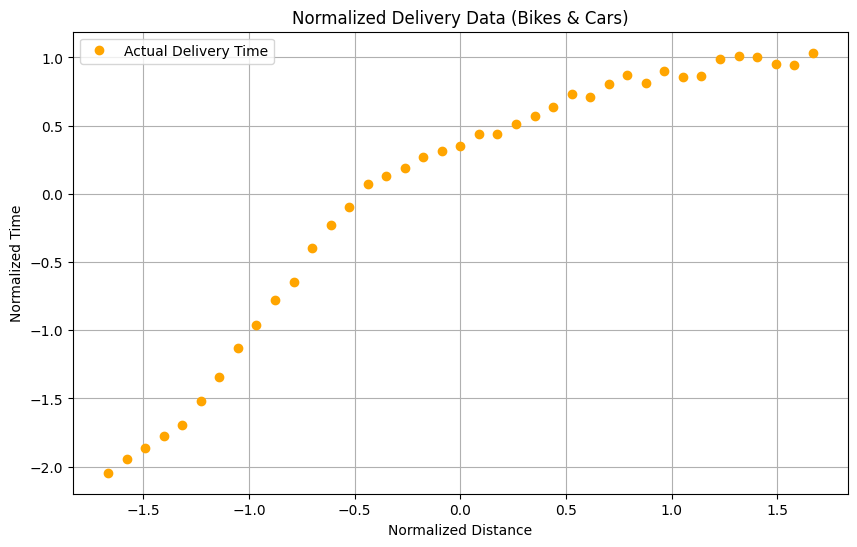

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))

plt.plot(distances_norm,times_norm,'o',label="Actual Delivery Time",color = "orange")
plt.title("Normalized Delivery Data (Bikes & Cars)")
plt.xlabel("Normalized Distance")
plt.ylabel("Normalized Time")
plt.legend()
plt.grid("True")
plt.show()

## Building the Non-Linear Model

With your normalized data ready, you can now build a model capable of learning its curved pattern. You will define the model's architecture, which now includes a `ReLU` activation function. This structure is what gives your model the ability to learn non-linear relationships.

* `nn.Linear(1, 3)`: This is your **first hidden layer**. It consists of three neurons, each receiving one input feature (the normalized distance). This layer transforms the single input value into three separate values.
* `nn.ReLU()` applies the ReLU activation function to the output of each of the three neurons from the hidden layer. This is the crucial non-linear step that allows your model to create "bends" and learn curves instead of just straight lines.
* `nn.Linear(3, 1)`: This is your **output layer**. It takes the three activated values from the previous step as its input and combines them to produce a single final output, which is your predicted (normalized) delivery time.

This creates a neural network with 1 hidden layer containing 3 neurons.

In [30]:
torch.manual_seed(42)

model = nn.Sequential(
    nn.Linear(1, 3),
    nn.ReLU(),
    nn.Linear(3,1)
)

## Training

* Define the loss function and the optimizer for training.

In [31]:
loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(),lr=0.01)

With your model and training tools ready, you can begin the training process.

* You will run the training loop for `3000` epochs (more than Lab 1 because the non-linear pattern is more complex and requires more training). This will repeatedly feed the *normalized* data to your model, measure the error, and adjust the model's parameters to improve its predictions.


## Checking the Final Fit 

Now that training is complete, you will visualize the result.

* You will plot your model's final predicted curve against the original data points.

In [34]:
for epoch in range(3000):
    optimizer.zero_grad()
    outputs = model(distances_norm)
    loss = loss_function(outputs,times_norm)
    loss.backward()
    optimizer.step()
    
    if(epoch+1)%500 == 0:
        print(f"Epoch {epoch+1}: Loss = {loss.item()}")

print("\nTraining complete")
print(f"final loss: {loss.item()}")



Epoch 500: Loss = 0.004000919405370951
Epoch 1000: Loss = 0.003945006988942623
Epoch 1500: Loss = 0.003918298054486513
Epoch 2000: Loss = 0.003905654652044177
Epoch 2500: Loss = 0.0038997058290988207
Epoch 3000: Loss = 0.003896926064044237

Training complete
final loss: 0.003896926064044237


## Making a Prediction

With your fully trained non-linear model, you can now use it to make a prediction for a new delivery. The process is slightly different now because your model was trained on *normalized* data.

* First, you will take the new input distance and **normalize** it using the same mean and standard deviation from your training data. This step is CRITICAL: your model has no idea about the original scales (miles and minutes). It only understands the normalized scale it was trained on.
* After the model provides its prediction, you must **de-normalize** the output. This converts the prediction from its normalized scale back into an understandable value in minutes.
* Finally, the code uses this actual predicted time to run the decision logic. For this prediction, assume your company now promises deliveries within 45 minutes (instead of 30 minutes from Lab 1) and wants to know which vehicle to use.

In [39]:
distance_to_predict = 5.1
with torch.no_grad():
    distance_tensor = torch.tensor([[distance_to_predict]],dtype=torch.float32)
    new_distance_norm = (distance_tensor - distances_mean)/distances_std

    predicted_time_norm = model(new_distance_norm)
    predicted_time_actual = (predicted_time_norm * times_std) + times_mean

    print(f"Prediction for a {distance_to_predict}-mile delivery: {predicted_time_actual.item():.1f} minutes")

    if predicted_time_actual > 45:
        print("\nDecision: Do not promise the delivery in under 45 minutes")
    else:
        if distance_to_predict <=3:
            print(f"\nDecision: Yes, delivery is possuble. Since the distance is {distance_to_predict} miles (<= 3 miles),use a bike.")
        else:
            print(f"\nDecision: Yes, delivery is possuble. Since the distance is {distance_to_predict} miles (> 3 miles),use a car.")


Prediction for a 5.1-mile delivery: 38.3 minutes

Decision: Yes, delivery is possuble. Since the distance is 5.1 miles (> 3 miles),use a car.
